# Importing Libraries

Now for modelling, the package we need is Juliet and the same can be called by using import juliet. numpy and matplotlib are already discussed in the previous section. sympy is a python library for symbolic mathematics.

In [2]:
import juliet
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import os

font1 = {'family':'serif','color':'black'}

# Define Priors

The Juliet model works based on the nested sampling which in general uses the Bayesian statistics (already discussed above). so to model the light curve to the data we must have to provide some prior values.

To get the knowladge about different priors and how it works visit the following website :

https://juliet.readthedocs.io/en/latest/user/priorsnparameters.html

In [3]:
filename = 'Detrended & Combined Lightcurves/Combined_TOI_1148.fits' # Transit Data File
rv_datafile = 'Transit & RV Data/TOI_1148_RV.dat'                    # RV Data File
output_folder = 'TOI_1148_Global_Fit'                                # Folder in which Results will be saved

# Name of Target Star
Target_Star = 'TOI 1148'

# ---------------------------------------------------------------------------------------------------------

# Priors for different Parameters 
Period, Period_Deviation = [5.5514, 0.00009]           # Normal Distribution
Time, Time_Deviation = [2457000 + 1684.8164, 0.0002]   # Normal Distribution
r1_lower, r1_upper = [0, 1]                            # Uniform Distribution (r1_p1 : Espinoza (2018))
r2_lower, r2_upper = [0, 1]                              # Uniform Distribution (r2_p1 : Espinoza (2018))

# q1 & q2 are LD Parametrization of Kipping for two parameter LD Laws except logarithmic Law 
# uniform distribution : Suggested to fit in between [0, 1]

a, a_Deviation = [9.95,0.17]                           # Normal distribution
K_lower, K_upper = [0, 500]                            # Uniform distribution
mu_lower, mu_upper = [0, 500]                          # Uniform distribution
e_lower, e_upper = [0, 0.5]                            # Uniform distribution
w_lower, w_upper = [0, 90]                             # Uniform distribution

instrument_rv = 'TRES' # Instrument being used to collect RV Data
instruments = ['TRES'] # List of Instruments used to collect RV data
# ---------------------------------------------------------------------------------------------------------


# Define the master prior dictionary. First define the TRANSIT priors
priors = {}

# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'a_p1', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', \
         'K_p1', 'mu_'+instrument_rv, 'ecc_p1', 'omega_p1', 'sigma_w_'+instrument_rv]

# Distribution for each of the parameters:
dists = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'normal', 'loguniform', \
         'uniform', 'uniform', 'uniform', 'uniform', 'loguniform']


hyperps = [[Period, Period_Deviation], [Time, Time_Deviation], [r1_lower, r1_upper], [r2_lower, r2_upper], [0, 1], [0, 1],\
           [a, a_Deviation], 1.0, [0,0.1], [0.1, 1000], \
           [K_lower, K_upper], [mu_lower, mu_upper], [e_lower, e_upper], [w_lower, w_upper], [1, 10]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

This is how the priors.dat file looks like

| Prior        | Distribution           | Value  |
| ------------- |:-------------:| -----:|
|P_p1               |  normal         |      5.5514,9e-05        |
|t0_p1              |  normal         |      2458684.8164,0.0002 |
|r1_p1              |  uniform        |      0,1                 |
|r2_p1              |  uniform        |      0,1                 |
|q1_TESS            |  uniform        |      0,1                 |
|q2_TESS            |  uniform        |      0,1                 |
|a_p1               |  uniform        |      9.95,0.17           |
|mdilution_TESS     |  fixed          |      1.0                 |
|mflux_TESS         |  normal         |      0.0,0.1             |
|sigma_w_TESS       |  loguniform     |      0.1,1000.0          |
|K_p1               |  uniform        |      0,500               |
|mu_TRES            |  uniform        |      0,500               |
|ecc_p1             |  uniform        |      0.0,0.5             |
|omega_p1           |  uniform        |      0,90                |
|sigma_w_TRES       |  loguniform     |      1,10                |

# Data Fitting (Transit + RV)

For this data fitting process we need to load the data files and prior files using the code `juliet.load` along with the path to the output folder to which the results will be stored. The data fitting process can be initiated by the code `juliet.fit` in which we need to provide some fitting parameters discussed on the website of Juliet Documentation, the link for the same is given below.

https://juliet.readthedocs.io/en/latest/user/api.html

In [4]:
# First get TESS photometric data
t, f, ferr = juliet.get_TESS_data(filename)

# Put data in dictionaries, add 2457000 to the times to convert from TESS JD to JD:
times, fluxes, fluxes_error = {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t + 2457000, f, ferr

# RV data is given in a file, so let's just pass the filename to juliet and load the dataset:
dataset = juliet.load(priors = priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, rvfilename = rv_datafile, \
                      out_folder = output_folder)

# And now let's fit it!
results = dataset.fit(sampler = 'dynesty', n_live_points = 500, nwalkers = 100000, nsteps = 300000, nburnin = 500000, \
                      emcee_factor = 0.0001, ecclim = 1.0, pl = 0.0, pu = 1.0, ta = 2457000.0, \
                      nthreads = None, use_ultranest = False, dynamic = True, \
                      dynesty_bound = 'multi', dynesty_sample = 'rwalk', dynesty_nthreads = None, \
                      dynesty_n_effective = np.inf, dynesty_use_stop = True, dynesty_use_pool = None)

Detected dynesty sampler output files --- extracting from TOI_1148_Global_Fit/_dynesty_NS_posteriors.pkl


# Transit Lightcurve

The above section will take some time to fit the data and will store the results to the given location in a file `titled_dynesty_NS_posteriors.pkl`. This file is not in human readable format. The calculated parameters from the previously mentioned file are stored into the file titled `posteriors.dat`. Now to plot the transit light curve model fitted to the data can be done by the following code. Now we call the model parameters from the results.lc file and from the evaluated parameters we define the phases to period fold the light curve. This process is done below in the section entitled "Evaluating the Model". The plotting part is initiated into the further section having a title "Plotting the Model & Data".

### 1. Evaluating the Model

In [5]:
transit_model = results.lc.evaluate('TESS') # Evaluating the model

# ------------------------------------------------------------------------------------------
# Extract period and time of transit center for the planet
# ------------------------------------------------------------------------------------------
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# ------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------
phases0 = juliet.get_phases(dataset.times_lc['TESS'], P, t0) 
idx0 = np.argsort(phases0)
p_bin, y_bin, yerr_bin = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0], 100) # Data binning

### 2. Plotting the Model & Data

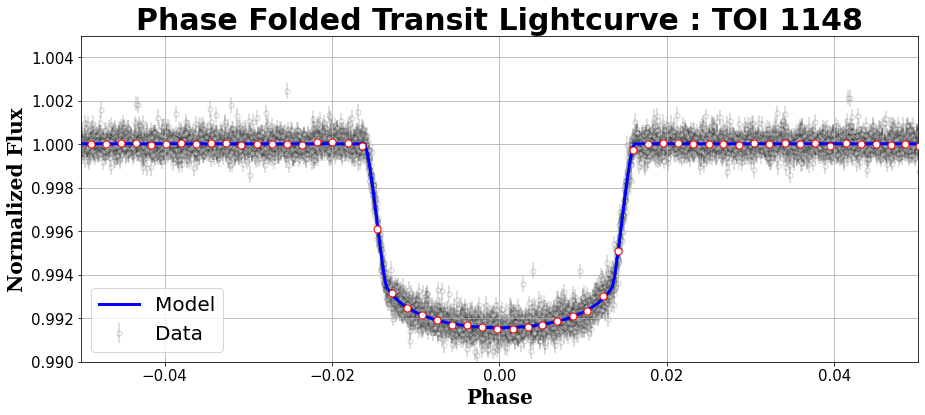

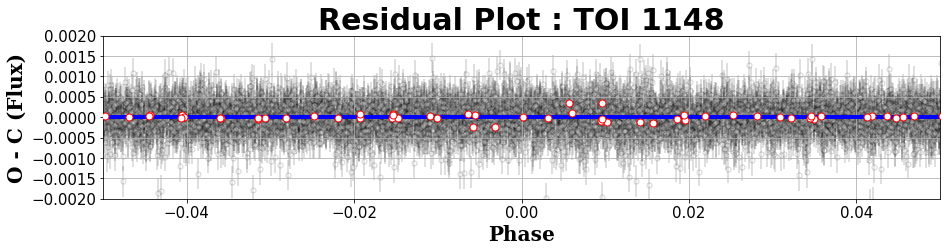

In [6]:
# ------------------------------------------------------------------------------------------
# Plotting the Graph
# ------------------------------------------------------------------------------------------
plt.figure()

plt.errorbar(phases0, dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1) # Plot whole data set in background

plt.plot(phases0[idx0],transit_model[idx0], color='b', lw = 3, zorder = 2) # Plot the model 

plt.errorbar(p_bin, y_bin, yerr = yerr_bin, fmt='ro', mfc = 'white',markersize=7, zorder = 3) # Plot the binned data for reference


# ------------------------------------------------------------------------------------------
# Graph Designs
# ------------------------------------------------------------------------------------------
plt.title("Phase Folded Transit Lightcurve : %s" %(Target_Star), weight = "bold",fontsize="30")
plt.xlabel('Phase',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('Normalized Flux',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(["Model", "Data"], prop={'size': 20})
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,6)

plt.xlim([-0.05, 0.05])
plt.ylim([0.990, 1.0050])

# Residual Plot
plt.figure()

p_bin1, y_bin1, yerr_bin1 = juliet.bin_data(phases0, transit_model - dataset.data_lc['TESS'], 100) # Data binning

plt.errorbar(phases0, transit_model - dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1)

plt.plot(phases0, np.zeros(np.size(phases0)), color='b', lw = 3, zorder = 2)

plt.errorbar(p_bin1, y_bin1, yerr = yerr_bin1, fmt='ro', mfc = 'white',markersize=7, zorder = 3)

plt.title("Residual Plot : %s" %(Target_Star), weight = "bold",fontsize="30")
plt.xlabel('Phase',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('O - C (Flux)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,3)

plt.xlim([-0.05, 0.05])
plt.ylim([-0.002, 0.002])

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' Transit.jpeg'), format='jpeg', dpi=1200)

This how the Transit light curve looks like. The gray points you can see in the background are the data points along with the errorbars. Blue line is the fitted model, and the red dots are the binned data using which we can easily observe how the model is fitted to the data.

# Radial Velocity Lightcurve

Same things as we did for the transit light curve need to be done to plot the radial velocity curve. minimum time and maximum time can be identified from the data and accordingly phases are defined.

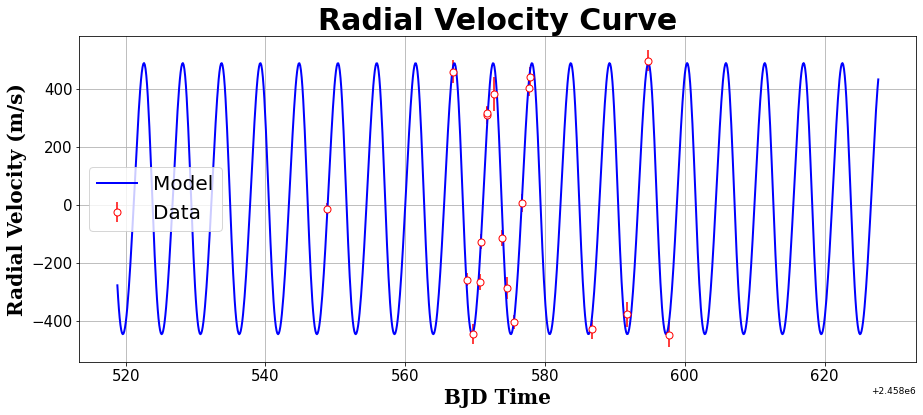

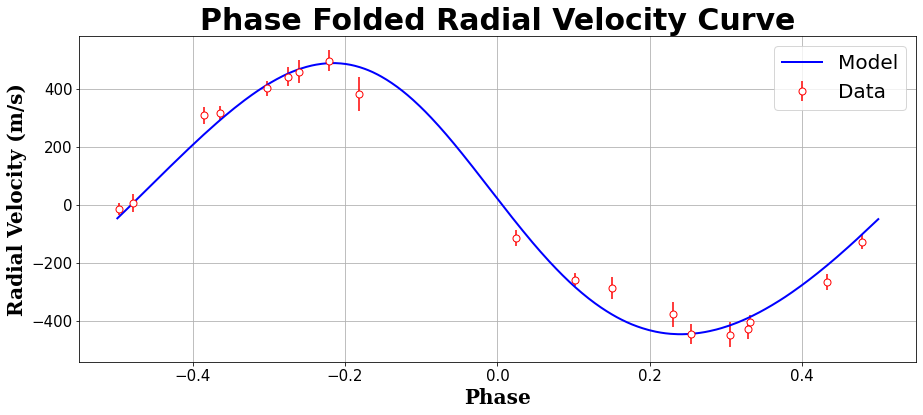

In [7]:
# ---------------------------------------------------------------------------------
# Define time staps
# ---------------------------------------------------------------------------------
min_time, max_time = np.min(dataset.times_rv[instrument_rv])-30,\
                            np.max(dataset.times_rv[instrument_rv])+30  # Max & Min Time

model_rv_times = np.linspace(min_time, max_time,1000) # Time Steps


# ---------------------------------------------------------------------------------
# Evaluate RV Model (Use all the posterior samples, also extract model components)
# ---------------------------------------------------------------------------------
rv_model, components = results.rv.evaluate(instrument_rv, t = model_rv_times, all_samples = True, \
                                           return_components = True)

rv_model -= components['mu'] # Subtract the mean term to normalize the LC


# ---------------------------------------------------------------------------------
# Iterate through the instruments 
# Evaluate a model at those times
# ---------------------------------------------------------------------------------

# Radial Velocity Curve
plt.figure()
for i in range(len(instruments)):
    
    instrument = instruments[i]
    
    # Evaluate jitter level (will be added in quadrature to data errors)
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    
    # Plot data with the (full model - planet 1) substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples = True, return_components = True)
    
    # Now plot RV data with (best model - planet component) substracted:
    plt.errorbar(dataset.times_rv[instrument_rv], dataset.data_rv[instrument]- (c_model - c_components['p1']),\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2), fmt='ro', mfc = 'white',markersize=7)


plt.plot(model_rv_times, rv_model, color='b', lw = 2)

plt.title("Radial Velocity Curve", weight = "bold",fontsize="30")
plt.xlabel('BJD Time',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('Radial Velocity (m/s)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(["Model", "Data"], prop={'size': 20})
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,6)

# ---------------------------------------------------------------------------------
# Phase Folded Light Curve
# ---------------------------------------------------------------------------------
plt.figure()
for i in range(len(instruments)):
    
    instrument = instruments[i]
    
    # Evaluate jitter level (will be added in quadrature to data errors)
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    
    # Get phases
    phases1 = juliet.get_phases(dataset.times_rv[instrument], P, t0)
    
    # Plot data with the (full model - planet 1) substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples = True, return_components = True)
    
    # Now plot RV data with (best model - planet component) substracted:
    plt.errorbar(phases1, dataset.data_rv[instrument]- (c_model - c_components['p1']),\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2), fmt='ro', mfc = 'white',markersize=7)


# ------------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------------
phases2 = juliet.get_phases(model_rv_times, P, t0)
idx = np.argsort(phases2)


# ------------------------------------------------------------------------------------------
# Plotting the Model on the Data
# ------------------------------------------------------------------------------------------
plt.plot(phases2[idx], components['p1'][idx], color='b', lw = 2)


plt.title("Phase Folded Radial Velocity Curve", weight = "bold",fontsize="30")
plt.xlabel('Phase',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('Radial Velocity (m/s)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(["Model", "Data"], prop={'size': 20})
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,6)

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' RV.jpeg'), format='jpeg', dpi=1200)

This is how the radial velocity curve looks like. The red dots are actual data and
the blue line is the model fitted to the data. The parameters estimated from the
Juliet are in the folder `TOI_1148_Global_Fit`